In [1]:
import numpy as np
import matplotlib.pyplot as plt
import omero
from omero.gateway import BlitzGateway
import time
from skimage import filters
import os

from tqdm import tqdm
from ipywidgets import Password, Text, ToggleButton, Checkbox, IntSlider
from multi_label_pigeon import annotate
from skimage.exposure import rescale_intensity


# Set up connection to OMERO

In [2]:
global user
global pw
user = Text(description='User:', placeholder='Your Omero Login')

pw = Password(description='Password:', placeholder='Enter password for login')

In [3]:
user

Text(value='', description='User:', placeholder='Your Omero Login')

In [4]:
pw

Password(description='Password:', placeholder='Enter password for login')

# Define Functions

In [5]:
def refresh_omero_session(conn):
    if conn==None:
        USERNAME = user.value
        PASSWORD = pw.value
        HOST = "134.76.18.202"
        PORT=   4064

        c = omero.client(host=HOST, port=4064)
        session = c.createSession(USERNAME,PASSWORD)

        print("Connected.")
        conn = BlitzGateway(USERNAME, PASSWORD,host=HOST, port=PORT)
    else:
        #if conn.isConnected():
            #conn.keep_alive()
        
        USERNAME = user.value
        PASSWORD = pw.value
        HOST = "134.76.18.202"
        PORT=   4064

        c = omero.client(host=HOST, port=4064)
        session = c.createSession(USERNAME,PASSWORD)

        print("Connected.")
        conn = BlitzGateway(USERNAME, PASSWORD,host=HOST, port=PORT)
    conn.connect()
    print(conn.isConnected())
    return conn


In [6]:
def load_data(run_):
    width=101
    height=101
    half_width=int(width/2.)
    half_height=int(height/2.)
    c_max = 4
    list_batch_images= []
    list_xy_batch_images =  []
    for id_n, id_ in tqdm(enumerate(range(min(batch_size,len(precondition)-run_*batch_size)))):
        image = np.zeros((width,height,c_max))
        image_id = precondition[id_+run_*batch_size]
        for c in range(0,c_max):
            image[:,:,c]=pixels.getTile(0,theC=c,theT=0,tile=[x[image_id]-half_width,y[image_id]-half_height,width,height])
        list_batch_images.append(image)
        list_xy_batch_images.append((id_n,x[image_id],y[image_id]))
    return list_batch_images, list_xy_batch_images

In [7]:
def show_cell(image):
    %matplotlib notebook
    log_dapi = np.log(image[:,:,0])
    log_dapi[np.isinf(-log_dapi)] = 10**(-14) 
    dapi = rescale_intensity(log_dapi,out_range=(0, 1.))
    ## threshold for display
    display_threshold_channel_1 = 2*threshold
    display_threshold_channel_3 = 100
    fluorescence = rescale_intensity(image[:, :, 1], in_range=(0,display_threshold_channel_1),out_range=(0, 1))
    fluorescence_3 = rescale_intensity(image[:, :, 3], in_range=(0,display_threshold_channel_3), out_range=(0, 1))
    dapi_rgb = np.dstack((np.zeros_like(dapi), np.zeros_like(dapi), dapi))
    fluorescence_rgb = np.dstack((np.zeros_like(dapi), fluorescence, np.zeros_like(dapi)))
    fluorescence_2_rgb = np.dstack((fluorescence_3, np.zeros_like(dapi), fluorescence_3))
    dapi_fluorescence_rgb = np.dstack((np.zeros_like(dapi), fluorescence, dapi))
    fig,(ax) = plt.subplots(2,2)
    ax[0][0].imshow(dapi_rgb)#, alpha = 0.5)
    ax[0][0].plot(50,50,'wx')
    ax[0][1].imshow(fluorescence_rgb)
    #,clim=[0,2000])#,alpha = 0.5)
    ax[0][1].plot(50,50,'wx')
    ax[1][0].imshow(dapi_fluorescence_rgb)
    ax[1][1].imshow(fluorescence_2_rgb)
    

# Set up connection to Omero and load pointer to the image

In [9]:
try: conn
except NameError: conn = None
conn = refresh_omero_session(conn)

## Image you want to analyse ##########
imageId = 3062
################################

conn.SERVICE_OPTS.setOmeroGroup('-1')
image = conn.getObject("Image", imageId)
group_id = image.getDetails().getGroup().getId()
print("Switched Group to Group of image: ", group_id)
conn.setGroupForSession(group_id)
pixels = image.getPrimaryPixels()
size_x = image.getSizeX()
size_y = image.getSizeY()
global input_range
input_range= image.getPixelRange()
pixels

Connected.
True
Switched Group to Group of image:  203


<_PixelsWrapper id=3062>

# Monte Carlo Sampling of staining intensity

define fluorescence channel of interest. At the moment I did not test if it works with a channel different than 1



In [10]:
channel_of_interest = 1

In [11]:
size_crop = 100
n_of_monte_carlo_image = 5
np.random.seed(10)
rand_x = np.random.randint(size_crop,size_x-size_crop,n_of_monte_carlo_image)
rand_y = np.random.randint(size_crop,size_y-size_crop,n_of_monte_carlo_image)

In [12]:
pixels_list = []
for id_ in tqdm(np.arange(len(rand_x))):
    pixels_list.append(pixels.getTile(0,theC=channel_of_interest,theT=0,tile=[rand_x[id_],rand_y[id_],size_crop,size_crop]))
    
pixels_list = np.squeeze(np.array(pixels_list))

100%|██████████| 5/5 [00:01<00:00,  4.38it/s]


In [13]:
global th_multi_otsu
th_multi_otsu= filters.threshold_multiotsu(pixels_list.flatten())

The calculated otsu multi threshold is: [342 487]


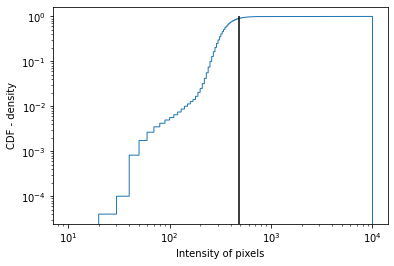

In [14]:
binspace = np.linspace(0,10000,1000)
plt.figure()
plt.hist(pixels_list.flatten(),cumulative=True,density=True,histtype='step', bins = binspace)
plt.vlines(th_multi_otsu[1],0,1)
plt.semilogx()
plt.semilogy()
plt.xlabel("Intensity of pixels")
plt.ylabel("CDF - density")
print("The calculated otsu multi threshold is: " + str(th_multi_otsu))

# Load centroids of nuclei

In [15]:
cods = np.loadtxt(str(imageId)+"_CellposeAllNucleiCentroids.txt",delimiter=",")
x = []
y= []
mean = []
median = []
var = []
skew = []
for p in tqdm(cods):
    x.append(p[0])
    y.append(p[1])
    mean.append(p[2])
    median.append(p[3])
    var.append(p[4])
    skew.append(p[5])
x = np.array(x)
y = np.array(y)
mean = np.array(mean)
median = np.array(median)
var = np.array(var)
skew = np.array(skew)

100%|██████████| 95827/95827 [00:00<00:00, 735981.46it/s]


In [19]:
width=101
height=101
half_width=int(width/2.)
half_height=int(height/2.)
c_max = 4

# Select subset for training

In [46]:
# parameters you can vary
batch_size=50

## select subset for annotation
# CHECK THRESHOLD ON Image
# the threshold is:
global threshold
threshold = 1000 # int(2*np.nanmedian(mean))    #nanmean austauschen gegen nanmedian th_multi_otsu[1] # or number or ...
condition = mean>threshold
# create list of ids of subimages to load
global precondition
list_images=np.arange(len(x))
precondition = list_images[condition]
fname= str(imageId)+"_training_results_Threshold_"+str(threshold)+".npy" ### TODO Threshold File
print("Your precondition requires you to label:" + str(np.sum(condition)) + " cells.")
print("Your threshold is: " + str(threshold))

Your precondition requires you to label:611 cells.
Your threshold is: 1000


/share/Work/Coding/CondaEnv37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [47]:
Load = Checkbox(value=True,description="Load existing dataset")
print("While this box is checked, you will try to load an existing dataset. \n \
      - uncheck if you process a dataset for the first time")
Load

While this box is checked, you will try to load an existing dataset. 
       - uncheck if you process a dataset for the first time


Checkbox(value=True, description='Load existing dataset')

In [48]:
if Load.value == False:
    complete_results = np.ones((2,len(precondition)))*np.nan
else:
    complete_results = np.load(fname)
n_runs = int(len(precondition)/batch_size)+1

In [49]:
print("You have to process run_ 0 till "+ str(n_runs-1)+".")
try:
    for label_id, label_ in enumerate(labeled_data):
        complete_results[0][label_id+run_*batch_size] = precondition[label_id+run_*batch_size]
        complete_results[1][label_id+run_*batch_size] = label_[1]
    print("So far you labeled: "+ str(np.sum(np.isnan(complete_results[0])!=1)))
    if autosave:
        np.save(fname,complete_results)
        print("Labels are saved under " + fname)
except:
    print("You just started.")
run_ = 4
print("Your current run number: " + str(run_))

You have to process run_ 0 till 12.
So far you labeled: 55
Labels are saved under 3062_training_results_Threshold_1000.npy
Your current run number: 4


In [50]:
autosave = Checkbox(value=True,description="Autosave")
print("While this box is checked, your data are saved after every batch round.")
autosave

While this box is checked, your data are saved after every batch round.


Checkbox(value=True, description='Autosave')

In [51]:
# automatically refresh before downloading
try: conn
except NameError: conn = None
conn = refresh_omero_session(conn)
conn.setGroupForSession(group_id)
image = conn.getObject("Image", imageId)
pixels = image.getPrimaryPixels()

# label data
list_batch_images,list_xy_batch_images = load_data(run_)
print(list_xy_batch_images)
%matplotlib notebook
labeled_data = annotate(list_batch_images,["0","1"],display_fn=lambda image: show_cell(image))



Connected.
True


50it [00:42,  1.17it/s]

[(0, 1865.0, 8738.0), (1, 1224.0, 8733.0), (2, 1263.0, 8743.0), (3, 830.0, 8741.0), (4, 1896.0, 8740.0), (5, 1909.0, 8740.0), (6, 1397.0, 8743.0), (7, 1369.0, 8750.0), (8, 1505.0, 8753.0), (9, 1350.0, 8748.0), (10, 1571.0, 8752.0), (11, 1339.0, 8752.0), (12, 1439.0, 8762.0), (13, 869.0, 8761.0), (14, 1719.0, 8765.0), (15, 1655.0, 8766.0), (16, 1153.0, 8780.0), (17, 1396.0, 8783.0), (18, 1591.0, 8788.0), (19, 1444.0, 8786.0), (20, 1770.0, 8800.0), (21, 1328.0, 8801.0), (22, 1549.0, 8805.0), (23, 1395.0, 8815.0), (24, 942.0, 8816.0), (25, 1464.0, 8817.0), (26, 1337.0, 8823.0), (27, 1508.0, 8817.0), (28, 1449.0, 8840.0), (29, 1377.0, 8845.0), (30, 1538.0, 8846.0), (31, 1432.0, 8855.0), (32, 1475.0, 8857.0), (33, 1525.0, 8869.0), (34, 1828.0, 8908.0), (35, 1236.0, 8922.0), (36, 1854.0, 8938.0), (37, 1847.0, 8956.0), (38, 956.0, 10544.0), (39, 995.0, 10558.0), (40, 859.0, 10567.0), (41, 859.0, 10594.0), (42, 866.0, 10609.0), (43, 1862.0, 10627.0), (44, 867.0, 10649.0), (45, 1807.0, 10645.0)

HTML(value='0 examples annotated, 51 examples left')

Output()

In [45]:
# save data
if autosave:
    for label_id, label_ in enumerate(labeled_data):
        complete_results[0][label_id+run_*batch_size] = precondition[label_id+run_*batch_size]
        complete_results[1][label_id+run_*batch_size] = label_[1]
    np.save(fname,complete_results)
    print("Labels are saved under " + fname)


1
0
1
0
0
Labels are saved under 3062_training_results_Threshold_1000.npy


In [43]:
SAVE_BOOL = Checkbox(value=False,description="Explicit save")
print("If this box is checked, you can manually save your data as well.")
SAVE_BOOL

If this box is checked, you can manually save your data as well.


Checkbox(value=False, description='Explicit save')

In [44]:
if SAVE_BOOL.value:
    np.save(fname,complete_results)


<IPython.core.display.Javascript object>


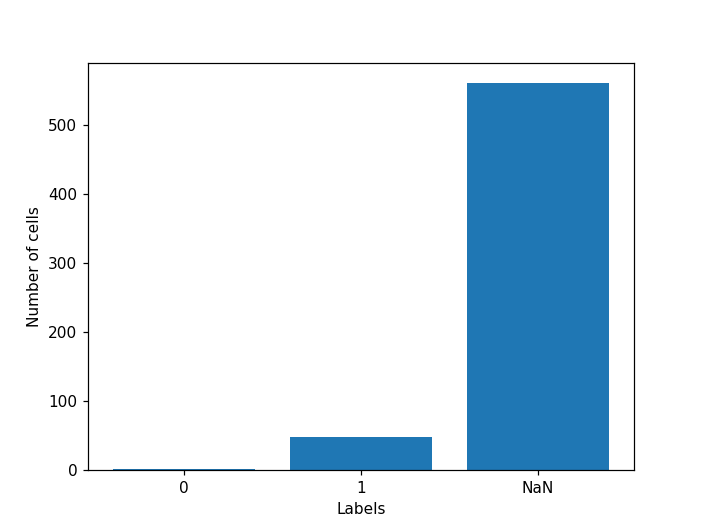

Text(0, 0.5, 'Number of cells')

In [41]:
plt.figure()
plt.bar([0,1,2],[np.sum(complete_results[1]==1),np.sum(complete_results[1]==0),np.sum(np.isnan(complete_results[1]))]);
plt.xticks([0,1,2,],["0","1","NaN"]);
plt.xlabel("Labels")
plt.ylabel("Number of cells")